In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        if twiny and twinx:
            return x_ax, y_ax
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [3]:
########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768]

W1_maglim = I_maglim

In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

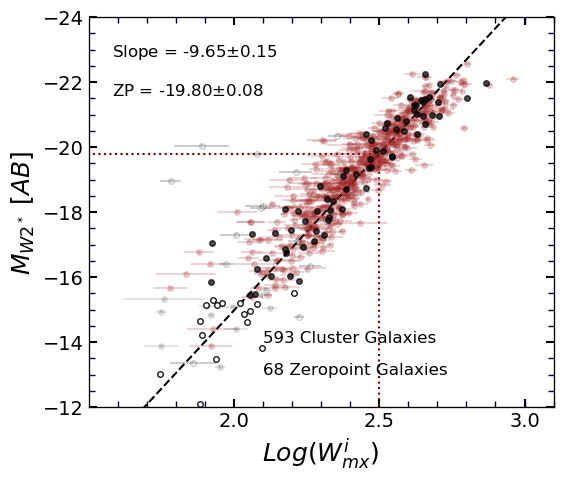

In [5]:
band='w2'
fig, ax, Clusters, S_ZP = makeTF(table, pgcFaint=W1_maglim, calib_maglim=calib_maglim, band=band, makePlot=True)

In [6]:
slope = S_ZP[0]
zp    = S_ZP[2]

zp_calibs = all_ZP(table, band=band, slope=slope, pgcFaint=calib_maglim)

MAGdict = {}
for key0 in Clusters:
#     key0 = 'NEST_100008'
    myCluster = Clusters[key0]
    zp_virgo  = myCluster['zp']

    MAG       = myCluster['mag']-zp_virgo+zp
    MAG_w     = myCluster['mag_w']-zp_virgo+zp
    logWimx   = myCluster['logWimx']
    logWimx_w = myCluster['logWimx_w']
    pgc       = myCluster['pgc']
    pgc_w     = myCluster['pgc_w']


    indx = []
    indx_ = []    
    for i, id in enumerate(pgc):
        if not id in W1_maglim:
            indx.append(i)
        else:
            indx_.append(i) # faint


    MAG_faint       = []
    logWimx_faint   = []
    pgc_faint       = []

    if len(indx_)>0:
        MAG_faint       = MAG[indx_]
        logWimx_faint   = logWimx[indx_]
        pgc_faint       = pgc[indx_]

    if len(indx)>0:
        MAG       = MAG[indx]
        logWimx   = logWimx[indx]
        pgc       = pgc[indx]
    
    d_modulus = zp_virgo-zp
    dist = 10**((d_modulus-25.)/5.)
    MAGdict[key0] = [MAG,  d_modulus, dist]
    

In [7]:
d_lst = []
keys = []
for key in MAGdict:
    d_lst.append(MAGdict[key][2])
    keys.append(key)
indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, Clusters[key]['name'], '--> %d'%MAGdict[key][2], MAGdict[key][1]

NEST_100002 Virgo --> 14 30.816425529694058
NEST_100008 Ursa Major --> 17 31.154687668255477
NEST_200015 Fornax --> 17 31.221183949473513
NEST_100003 Centaurus --> 33 32.61447227322531
NEST_100014 Antlia --> 35 32.77467686328049
NEST_200092 Pegasus --> 44 33.221146166093135
NEST_100006 Hydra --> 54 33.69227427812988
NEST_200003 Abell 262 --> 60 33.900213100603374
NEST_200005 NGC410 --> 63 33.99730481873886
NEST_200006 NGC507 --> 65 34.08039652514469
NEST_100030 Cancer --> 68 34.17513463705262
NEST_200045 NGC80 --> 75 34.40275037315705
NEST_200037 NGC70 --> 81 34.54701620544101
NEST_100005 Abell 1367 --> 94 34.86602583265949
NEST_100001 Coma --> 95 34.89895652832179
NEST_200012 Abell 400 --> 97 34.940141995675255
NEST_100018 NGC4065 --> 105 35.11422801003231
NEST_200017 Abell 539 --> 108 35.17191888703977
NEST_200016 Abell 2634/66 --> 115 35.3035960827311
NEST_100007 Abell 2151 (Hercules) --> 163 36.07213644351833


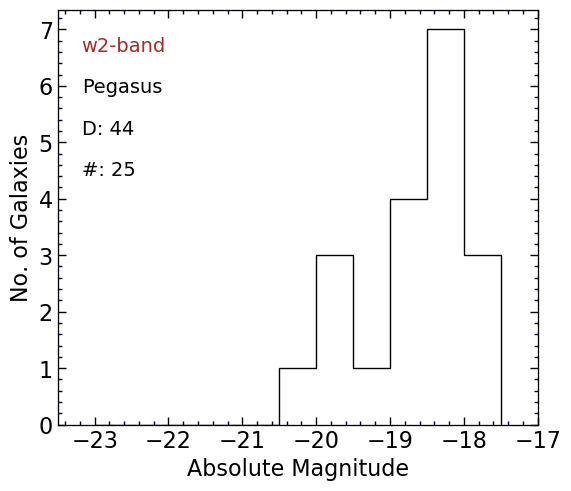

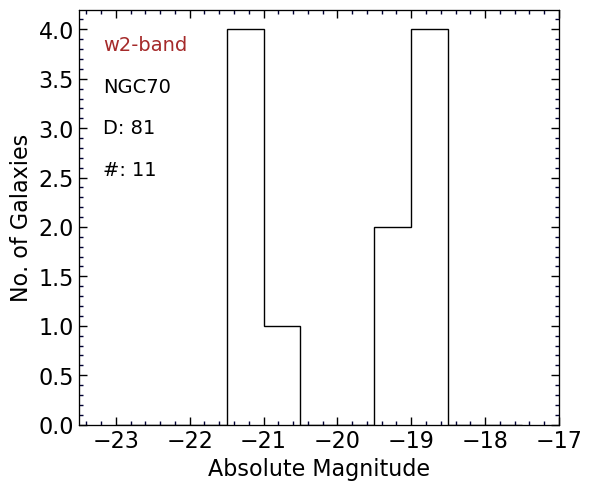

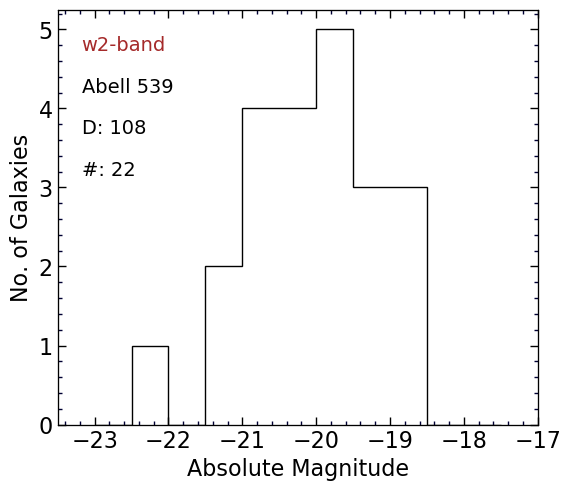

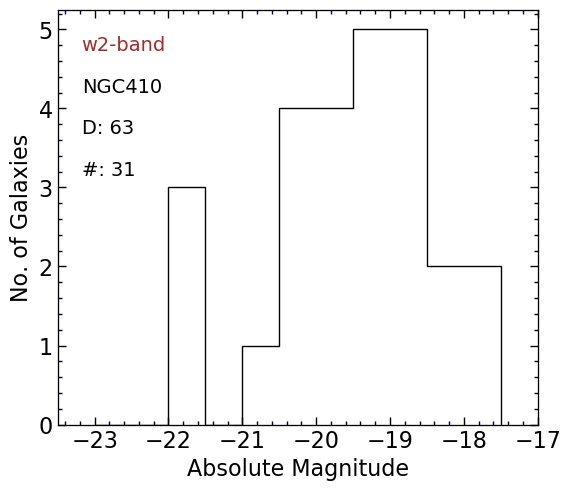

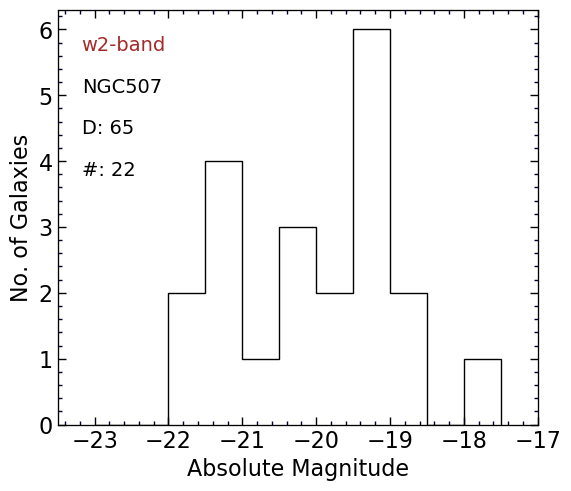

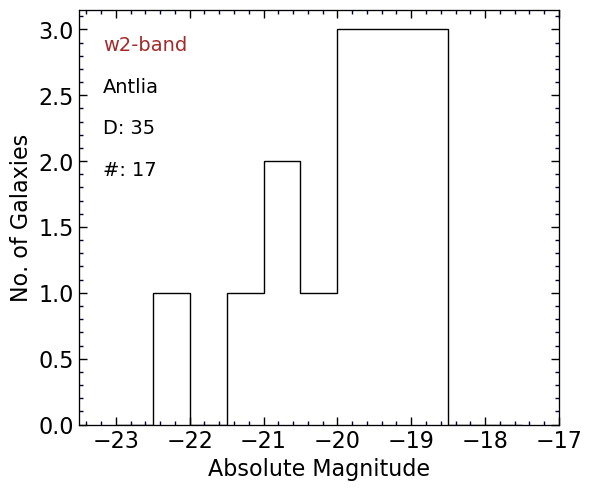

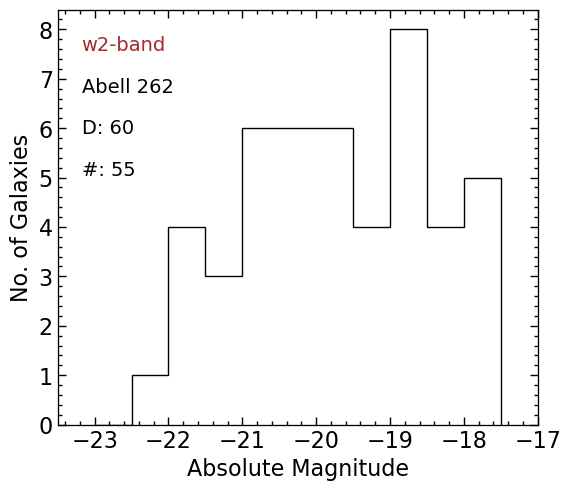

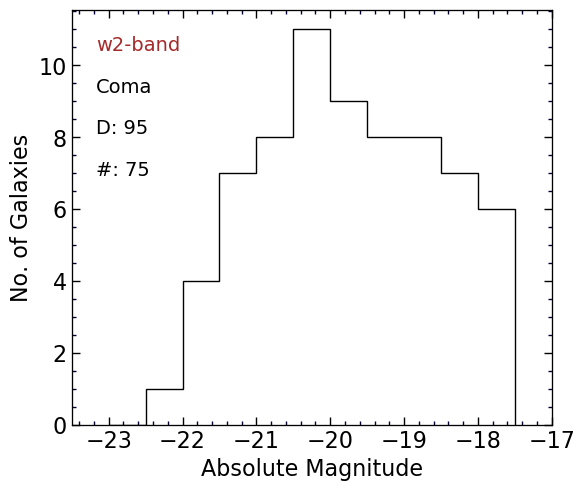

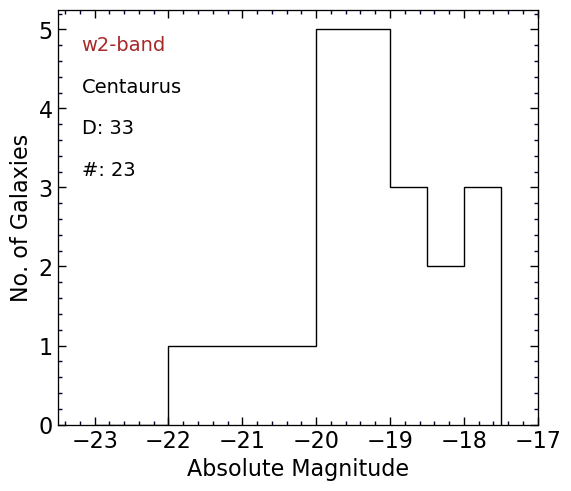

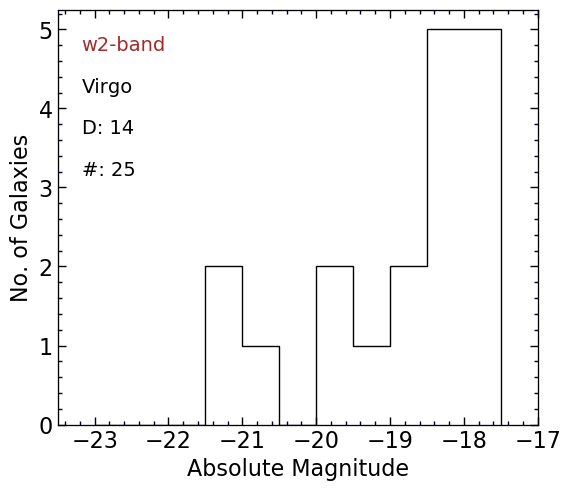

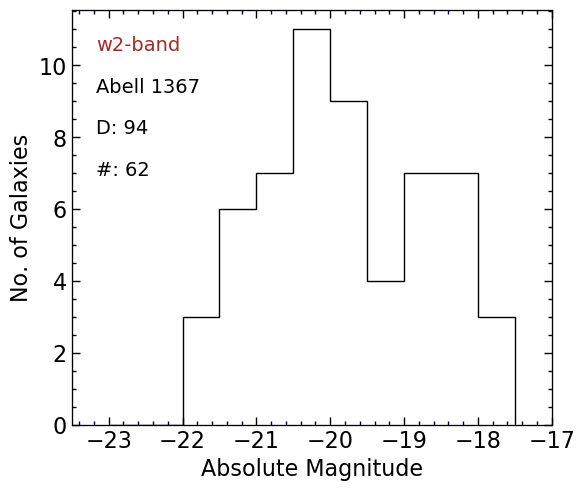

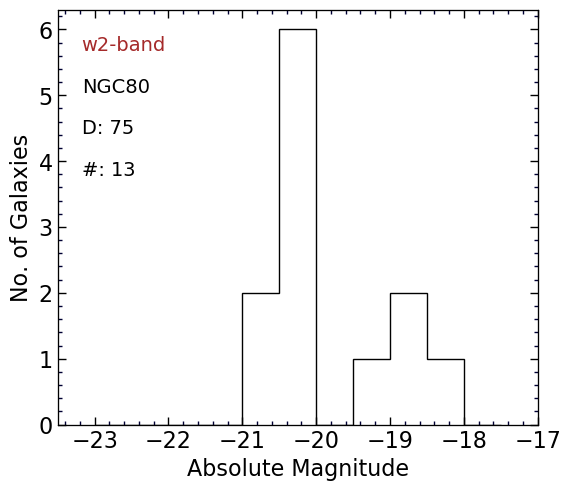

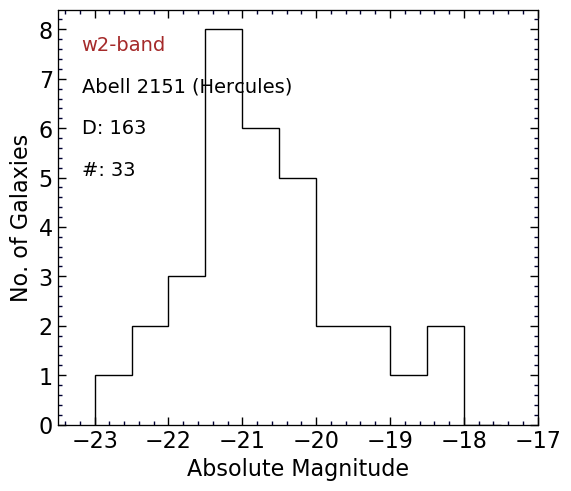

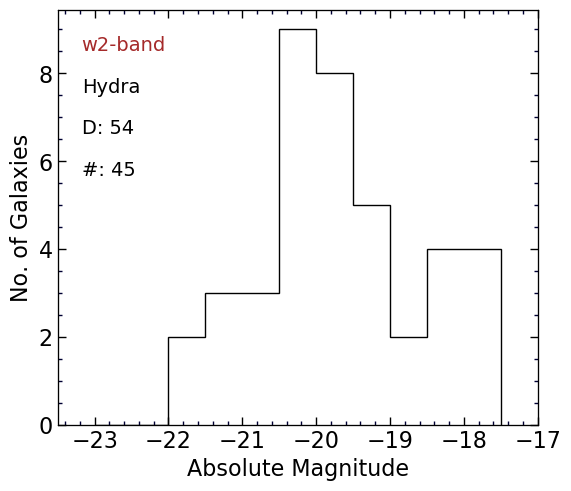

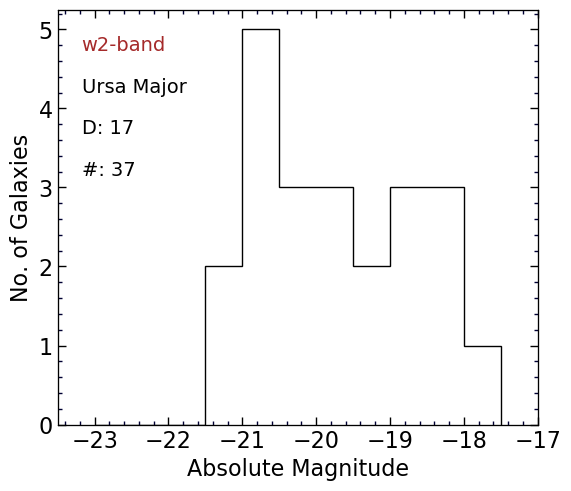

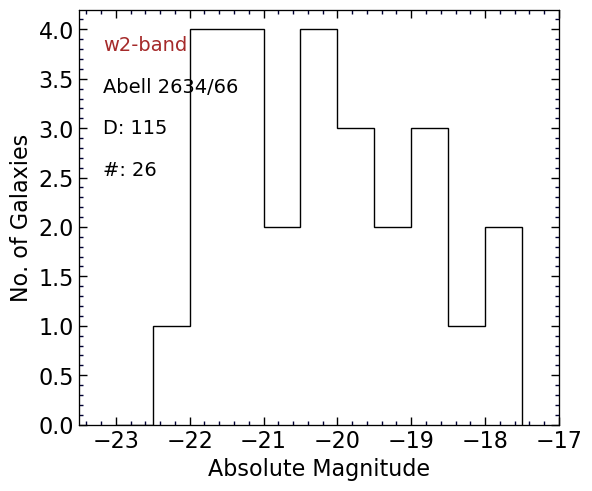

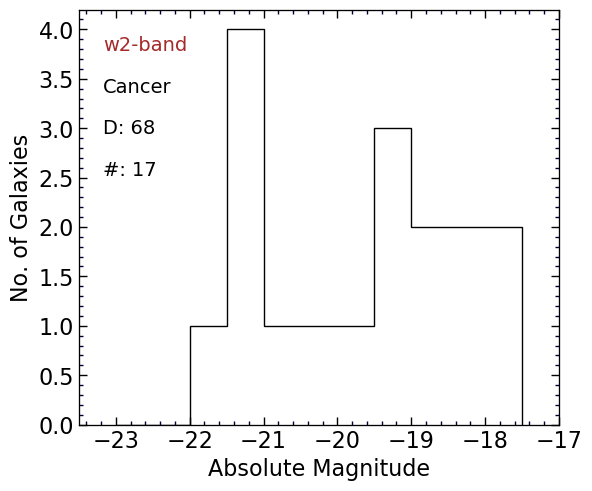

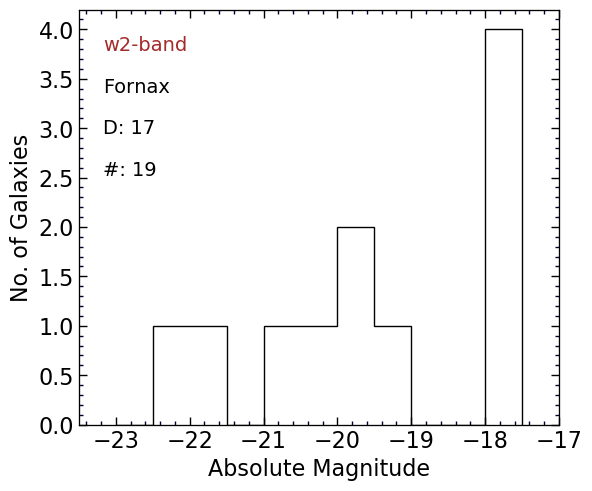

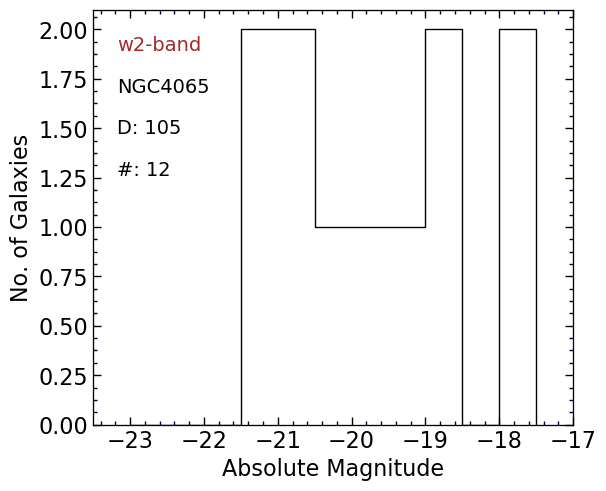

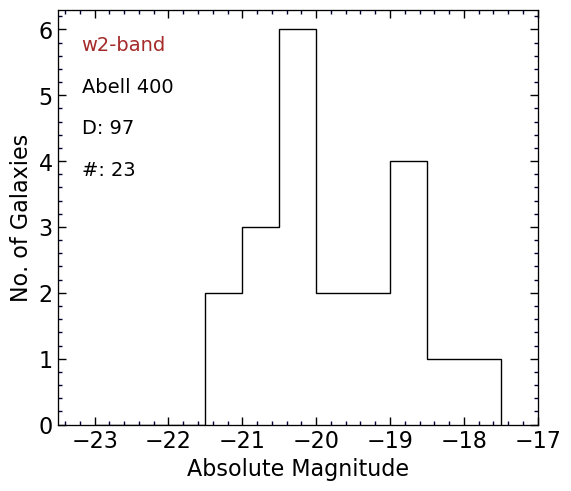

In [8]:
for key in Clusters:
    fig = py.figure(figsize=(6,5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
    ax = fig.add_subplot(111)
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

    bins = np.arange(-23,-17,0.5)

    ax.hist(MAGdict[key][0], bins=bins, histtype='step', label='whole sample', color='k')

    ax.set_xlim([-23.5,-17])

    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.95*Xlm[0]+0.05*Xlm[1]
    y0 = 0.1*Ylm[0]+0.9*Ylm[1]
    ax.text(x0,y0, band+'-band', fontsize=14, color=dye[band])
    y0 = 0.2*Ylm[0]+0.8*Ylm[1]
    ax.text(x0,y0, Clusters[key]['name'], fontsize=14, color='k')
    y0 = 0.3*Ylm[0]+0.7*Ylm[1]
    ax.text(x0,y0, 'D: '+'%d'%MAGdict[key][2], fontsize=14, color='k')
    y0 = 0.4*Ylm[0]+0.6*Ylm[1]
    ax.text(x0,y0, '#: '+'%d'%len(MAGdict[key][0]), fontsize=14, color='k')
    ax.set_xlabel('Absolute Magnitude', fontsize=16)
    ax.set_ylabel('No. of Galaxies', fontsize=16)

    set_axes(ax, Xlm, Ylm)

    fig.savefig(key+'_hist'+'_'+band+'.png')

31.06588366676297 16.33716643142989


(-23.5, -17)

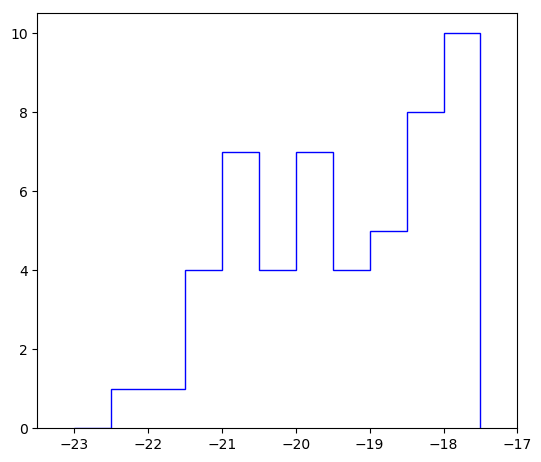

In [9]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23,-17,0.5)

MAGS1 = np.concatenate((MAGdict['NEST_100002'][0], MAGdict['NEST_200015'][0]))
MAGS1 = np.concatenate((MAGS1, MAGdict['NEST_100008'][0]))


mu1 = MAGdict['NEST_100002'][1]
mu2 = MAGdict['NEST_200015'][1]
mu3 = MAGdict['NEST_100008'][1]

g1 = len(MAGdict['NEST_100002'][0])
g2 = len(MAGdict['NEST_200015'][0])
g3 = len(MAGdict['NEST_100008'][0])


mu1_av =  (g1*mu1+g2*mu2+g3*mu3)/(g1+g2+g3)
dist1_av = 10**((mu1_av-25.)/5.)
print mu1_av, dist1_av



ax.hist(MAGS1, bins=bins, histtype='step',  color='b')

ax.set_xlim([-23.5,-17])

32.68255922399876 34.39630923849185


(-23.5, -17)

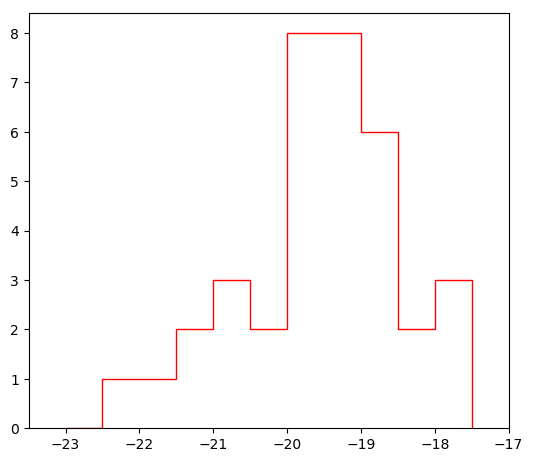

In [10]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23,-17,0.5)

MAGS2 = np.concatenate((MAGdict['NEST_100003'][0], MAGdict['NEST_100014'][0]))


mu1 = MAGdict['NEST_100003'][1]
mu2 = MAGdict['NEST_100014'][1]

g1 = len(MAGdict['NEST_100003'][0])
g2 = len(MAGdict['NEST_100014'][0])


mu2_av =  (g1*mu1+g2*mu2)/(g1+g2)
dist2_av = 10**((mu2_av-25.)/5.)
print mu2_av, dist2_av



ax.hist(MAGS2, bins=bins, histtype='step',  color='r')

ax.set_xlim([-23.5,-17])

33.69227427812988 54.75891767859732


(-23.5, -17)

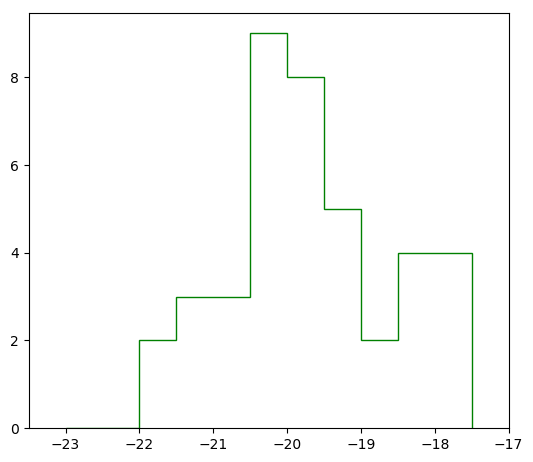

In [11]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23,-17,0.5)

MAGS3 = MAGdict['NEST_100006'][0]


mu3_av = MAGdict['NEST_100006'][1]
dist3_av = 10**((mu3_av-25.)/5.)
print mu3_av, dist3_av

ax.hist(MAGS3, bins=bins, histtype='step',  color='g')

ax.set_xlim([-23.5,-17])

33.88463552930143 59.831116311913156


(-23.5, -17)

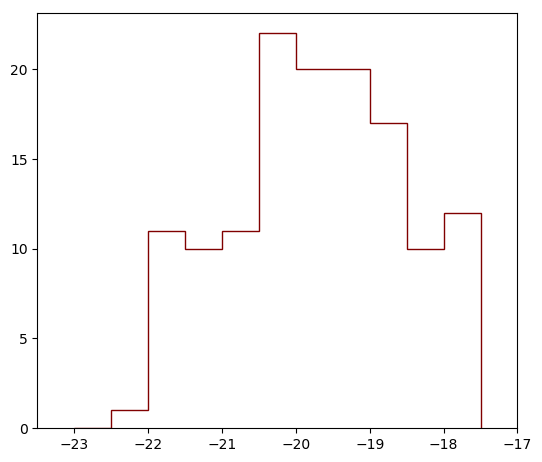

In [12]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23,-17,0.5)

MAGS4 = np.concatenate((MAGdict['NEST_200003'][0], MAGdict['NEST_200005'][0]))
MAGS4 = np.concatenate((MAGS4, MAGdict['NEST_200006'][0]))
MAGS4 = np.concatenate((MAGS4, MAGdict['NEST_100006'][0]))


mu1 = MAGdict['NEST_200003'][1]
mu2 = MAGdict['NEST_200005'][1]
mu3 = MAGdict['NEST_200006'][1]
mu4 = MAGdict['NEST_100006'][1]
g1 = len(MAGdict['NEST_200003'][0])
g2 = len(MAGdict['NEST_200005'][0])
g3 = len(MAGdict['NEST_200006'][0])
g4 = len(MAGdict['NEST_100006'][0])

mu4_av =  (g1*mu1+g2*mu2+g3*mu3+g4*mu4)/(g1+g2+g3+g4)
dist4_av = 10**((mu4_av-25.)/5.)
print mu4_av, dist4_av


ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')

ax.set_xlim([-23.5,-17])

34.97314577315114 98.77093264831058
36.07213644351833 163.84277262832924


(-23.5, -17)

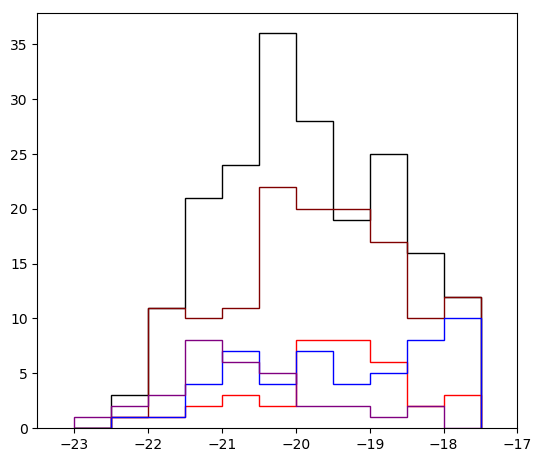

In [13]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23,-17,0.5)

MAGS = np.concatenate((MAGdict['NEST_100001'][0], MAGdict['NEST_100005'][0]))
MAGS = np.concatenate((MAGS, MAGdict['NEST_200012'][0]))
MAGS = np.concatenate((MAGS, MAGdict['NEST_200017'][0]))
MAGS = np.concatenate((MAGS, MAGdict['NEST_200016'][0]))


mu1 = MAGdict['NEST_100001'][1]
mu2 = MAGdict['NEST_100005'][1]
mu3 = MAGdict['NEST_200012'][1]
mu4 = MAGdict['NEST_200017'][1]
mu5 = MAGdict['NEST_200016'][1]
g1 = len(MAGdict['NEST_100001'][0])
g2 = len(MAGdict['NEST_100005'][0])
g3 = len(MAGdict['NEST_200012'][0])
g4 = len(MAGdict['NEST_200017'][0])
g5 = len(MAGdict['NEST_200016'][0])
mu_av =  (g1*mu1+g2*mu2+g3*mu3+g4*mu4+g5*mu5)/(g1+g2+g3+g4+g5)
dist_av = 10**((mu_av-25.)/5.)
print mu_av, dist_av



MAGS0 = MAGdict['NEST_100007'][0]
mu0_av =  MAGdict['NEST_100007'][1]
dist0_av = 10**((mu0_av-25.)/5.)
print mu0_av, dist0_av

n, bins, p = ax.hist(MAGS, bins=bins, histtype='step', color='k')
n4, bins, p = ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')
# n3, bins, p ax.hist(MAGS3, bins=bins, histtype='step',  color='g')
n2, bins, p = ax.hist(MAGS2, bins=bins, histtype='step',  color='r')
n1, bins, p = ax.hist(MAGS1, bins=bins, histtype='step',  color='b')
n0, bins, p = ax.hist(MAGS0, bins=bins, histtype='step',  color='purple')

ax.set_xlim([-23.5,-17])

In [14]:
import copy

def histJoint(n1, n, err1, bins, MAGlim, plotME=False, ax=None):

    indx, = np.where(bins<MAGlim)
    N1 = np.sum(n1[indx])
    m1 = copy.deepcopy(n1)
    m1[indx]=0
    
    err1_l = copy.deepcopy(err1)
    
    
    err1_r = copy.deepcopy(err1)
    
    
    err1_r[indx] = 0       # set left side to zero 
    indx, = np.where(bins>=MAGlim)
    err1_l[indx[:-1]] = 0   # set right side to zero

    indx, = np.where(bins<MAGlim)
    N = np.sum(n[indx])
     
    nt = copy.deepcopy(n)
    indx, = np.where(bins>=MAGlim)
    n[indx[:-1]] = 0
    
    
    hist = n+(n1+m1)*N/N1
    err = np.sqrt(n)
    err_hist = np.sqrt(err**2+(err1_l*N/N1)**2)+2*err1_r*N/N1
    
    if plotME:
        if ax is None:
            fig = py.figure(figsize=(6,5), dpi=100)    
            fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
            ax = fig.add_subplot(111)
        
        ax.set_xlim([-24,-17])        
        #ax.bar(bins[:-1]+0.25, n1*N/N1, width = 0.5, color='green',alpha=0.1)
        ax.bar(bins[:-1]+0.25, n, width = 0.5, color='k',alpha=0.3)  
#         ax.bar(bins[:-1]+0.25, nt, width = 0.5, color='k',alpha=0.1)
        ax.step(bins[:-1]+0.5, nt)
        
        #ax.bar(bins[:-1]+0.25, hist, width = 0.5, color='k', alpha=0.5)
        #ax.errorbar(bins[:-1]+0.25,hist,yerr=err_hist, fmt='ko')
        return ax, hist, err_hist, np.sum(n)
        
    return hist, err_hist
    



In [15]:
bins = np.arange(-23,-17,0.5)
print bins
n, bins, p = ax.hist(MAGS, bins=bins, histtype='step', color='k')
n4, bins, p = ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')
n1, bins, p = ax.hist(MAGS1, bins=bins, histtype='step',  color='b')
n2, bins, p = ax.hist(MAGS2, bins=bins, histtype='step',  color='r')


bins_ = np.arange(-23.25,-17,0.5)
print bins_
n_, bins_, p = ax.hist(MAGS, bins=bins_, histtype='step', color='k')
n4_, bins_, p = ax.hist(MAGS4, bins=bins_, histtype='step',  color='maroon')
n1_, bins_, p = ax.hist(MAGS1, bins=bins_, histtype='step',  color='b')
n2_, bins_, p = ax.hist(MAGS2, bins=bins_, histtype='step',  color='r')



[-23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5 -19.  -18.5 -18.  -17.5]
[-23.25 -22.75 -22.25 -21.75 -21.25 -20.75 -20.25 -19.75 -19.25 -18.75
 -18.25 -17.75 -17.25]


[-24.  -23.5 -23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5 -19.  -18.5
 -18.  -17.5 -17. ]


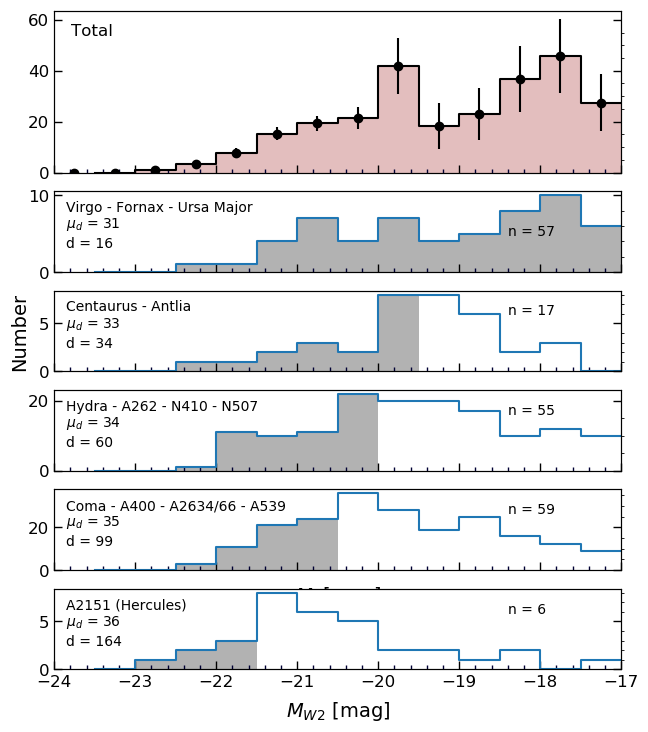

In [16]:
bins = np.arange(-24,-16.5,0.5)
print bins
n, bins, p = ax.hist(MAGS, bins=bins, histtype='step', color='k')
n4, bins, p = ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')
# n3, bins, p ax.hist(MAGS3, bins=bins, histtype='step',  color='g')
n2, bins, p = ax.hist(MAGS2, bins=bins, histtype='step',  color='r')
n1, bins, p = ax.hist(MAGS1, bins=bins, histtype='step',  color='b')
n0, bins, p = ax.hist(MAGS0, bins=bins, histtype='step',  color='purple')

# myHist0, err_hist0 = histJoint(n1, n2, np.sqrt(n1), bins, MAGlim=-20.5)
# myHist1, err_hist1 = histJoint(myHist0, n4, err_hist0, bins, MAGlim=-21)
# myHist2, err_hist2 = histJoint(myHist1, n, err_hist1, bins, MAGlim=-21.5)




fig = py.figure(figsize=(7, 7), dpi=100) 
fig.subplots_adjust(wspace=0, top=0.98, bottom=0.04, left=0.17, right=0.98)

gs = gridspec.GridSpec(6, 1, height_ratios=[2,1,1,1,1,1]) 


ax = plt.subplot(gs[1])
ax.step(bins[:-1]+0.5, n1)
ax.bar(bins[:-1]+0.25, n1, width = 0.5, color='k',alpha=0.3) 
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False) 
set_label(ax, 2, 75, 'Virgo - Fornax - Ursa Major', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu1_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist1_av, fontsize=10)
Ngray = np.sum(n1)
set_label(ax, 80, 45, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[2])
ax, myHist0, err_hist0, Ngray = histJoint(n1, n2, np.sqrt(n1), bins, MAGlim=-19.5, plotME=True, ax=ax)
# ax.set_yticks([5,10])
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False)   
ax.set_ylabel('Number', fontsize=14, labelpad=7)
set_label(ax, 2, 75, 'Centaurus - Antlia', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu2_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist2_av, fontsize=10)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[3])
ax, myHist1, err_hist1, Ngray = histJoint(myHist0, n4, err_hist0, bins, MAGlim=-20., plotME=True, ax=ax)
# ax.set_yticks([20])
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False) 
set_label(ax, 2, 75, 'Hydra - A262 - N410 - N507', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu4_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist4_av, fontsize=10)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[4])
ax, myHist15, err_hist15, Ngray = histJoint(myHist1, n, err_hist1, bins, MAGlim=-20.5, plotME=True, ax=ax)
# ax.set_yticks([5])
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
ax.set_xlabel(r'$M_{i}$'+' [mag]', fontsize=14, labelpad=7)
plt.setp(ax.get_xticklabels(), visible=False) 
set_label(ax, 2, 75, 'Coma - A400 - A2634/66 - A539', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist_av, fontsize=10)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[5])
ax, myHist2, err_hist2, Ngray = histJoint(myHist15, n0, err_hist15, bins, MAGlim=-21.5, plotME=True, ax=ax)
# ax.set_yticks([5])
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
ax.set_xlabel(r'$M_{W2}$'+' [mag]', fontsize=14, labelpad=7)
set_label(ax, 2, 75, 'A2151 (Hercules)', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu0_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist0_av, fontsize=10)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)


ax = plt.subplot(gs[0])
ax.bar(bins[:-1]+0.25, myHist2, width = 0.5, color='brown',alpha=0.3) 
ax.step(bins[:-1]+0.5, myHist2, color='k')
ax.errorbar(bins[:-1]+0.25,myHist2,yerr=err_hist2, fmt='ko')
# ax.set_yticks(np.arange(10,60,10))
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False)
set_label(ax, 3, 85, 'Total')
plt.subplots_adjust(hspace=.2, wspace=0)


[-23.75 -23.25 -22.75 -22.25 -21.75 -21.25 -20.75 -20.25 -19.75 -19.25
 -18.75 -18.25 -17.75 -17.25]
[ 0.          0.          1.          3.43723573  7.56276427 15.29098031
 19.31028042 21.41503022 41.88726037 18.31725855 22.89657319 36.63451711
 45.79314639 27.47588783]
-21.34726629511006 -0.9616592513262787
0.20599128943974043 0.09310585844492095
[-23.75 -23.25] [0. 0.]


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


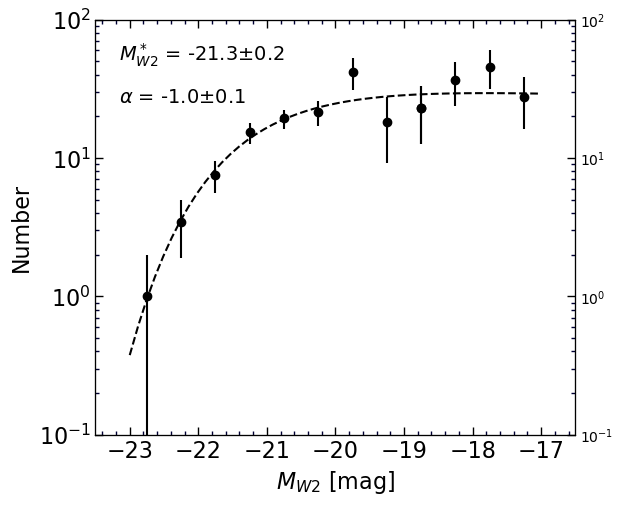

In [17]:
def LFfunction(M, fs, u, alpha):
    
    ms = -20+u
    dm = 0.4*(ms-M)
    c = 10.**dm
    b = fs*(c**(alpha+1)) 
    
    return b/np.exp(c)

def LFfunction1(M, fs, u):
    
    alpha = -1.0
    ms = -20+u
    dm = 0.4*(ms-M)
    c = 10.**dm
    b = fs*(c**(alpha+1)) 
    
    return b/np.exp(c)

xt = bins[:-1]+0.25
yt = myHist2

print xt
print yt


indx = [2,3,4,5,6,7,8,10,11,12,13,9,10]
x = xt[indx]
y = yt[indx]




fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-23.5,-16.5])
ax.errorbar(x,y,yerr=err_hist2[indx], fmt='ko')



M = np.linspace(-23,-17,50)
fit, cov = curve_fit(LFfunction, x, y, sigma=err_hist2[indx]) 
fs = fit[0]; u = fit[1]; alpha = fit[2]
N = LFfunction(M, fs, u, alpha)
ax.plot(M,N,'k--')
print u-20., alpha
print np.sqrt(cov[1][1]), np.sqrt(cov[2][2])

# fit, cov = curve_fit(LFfunction1, x, y, sigma=err_hist2[indx]) 
# fs = fit[0]; u = fit[1]; alpha = -1 # fit[2]
# N = LFfunction1(M, fs, u)
# ax.plot(M,N,'K--')
# print u-20., alpha
# print np.sqrt(cov[1][1])


indx = [0,1]
ax.errorbar(xt[indx],yt[indx],yerr=err_hist2[indx], fmt='ko', mfc='white')
print xt[indx],yt[indx]


ax.set_yscale("log", nonposy='clip')

ax.set_xlabel(r'$M_{W2}$'+' [mag]', fontsize=16)
ax.set_ylabel('Number', fontsize=16)

ax_x, ax_y = set_axes(ax, [-23.5,-16.5], [0.1,100])
ax_y.set_yscale("log", nonposy='clip')

set_label(ax, 5, 50, r'$M^*_{W2}$'+' = %.1f'%(u-20)+r'$\pm$'+'%.1f'%np.sqrt(cov[1][1]), fontsize=14, color='k')
set_label(ax, 5, 25, r'$\alpha$'+' = %.1f'%alpha+r'$\pm$'+'%.1f'%np.sqrt(cov[2][2]), fontsize=14, color='k')